# Predict earnings of stocks over a ~2.5 day window (D, D+1, D+2).

#### The data provided list the following returns on which to train a predictor (provided only in training set):

1. Returns from D-2 (closing price)

2. Returns from D-1 (closing price)

3. Returns for each of 180 minutes on D

#### The competition asks for the following future returns (provided in training and test sets):

1. Returns for minutes 121-180 in D

2. Returns for D+1 (closing price)

3. Returns for D+2 (closing price)

Also provided are some unnamed features (25 of them) as well as some sort of weight for A) 120 minutes on D, B) D+1 and D+2 closing prices. I'm not quite sure what those weights are.

In [16]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
%matplotlib inline

### Importing the data
The training set is pretty big, but I can load it with pandas so I'll do that. First, though, I want to look at the headers

In [17]:
### FILE I/O BLOCK
####################################################

with open("../../data/stocks_2015/train.csv") as f:
    headers = f.readline().strip('\r\n').split(',')
    print headers
f.close()

['Id', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_2', 'Ret_3', 'Ret_4', 'Ret_5', 'Ret_6', 'Ret_7', 'Ret_8', 'Ret_9', 'Ret_10', 'Ret_11', 'Ret_12', 'Ret_13', 'Ret_14', 'Ret_15', 'Ret_16', 'Ret_17', 'Ret_18', 'Ret_19', 'Ret_20', 'Ret_21', 'Ret_22', 'Ret_23', 'Ret_24', 'Ret_25', 'Ret_26', 'Ret_27', 'Ret_28', 'Ret_29', 'Ret_30', 'Ret_31', 'Ret_32', 'Ret_33', 'Ret_34', 'Ret_35', 'Ret_36', 'Ret_37', 'Ret_38', 'Ret_39', 'Ret_40', 'Ret_41', 'Ret_42', 'Ret_43', 'Ret_44', 'Ret_45', 'Ret_46', 'Ret_47', 'Ret_48', 'Ret_49', 'Ret_50', 'Ret_51', 'Ret_52', 'Ret_53', 'Ret_54', 'Ret_55', 'Ret_56', 'Ret_57', 'Ret_58', 'Ret_59', 'Ret_60', 'Ret_61', 'Ret_62', 'Ret_63', 'Ret_64'

#### For reference, here is a list of indices and what they correspond to:

- col_0 = stock id

- col_1 - col_25 = features (I won't worry about these yet)

- col_26 = D-2 return

- col_27 = D-1 return

- col_28 - col_206 = returns for the first 180 minutes in D

- col_207 = return for D+1

- col_208 = return for D+2

- col_209 = weight for minutes 121-180 in D returns

- col_210 = weight for D+1 and D+2 returns

I should also note what they actually want. The submission should include **returns**, which means the **marginal change in price (probably shown in %) over the course of that time period**. So for the minutes 121-180 on D the return is going to be about 2 orders of magnitude lower than the returns for D+1 and D+2.

# Initial thoughts:
Stock data is notoriously stochastic and the leaderboard for this competition is very tight. I don't think it's even worth trying to predict the t_120 - t_180 data points so I will just focus on the D+1 and D+2 whole day returns and leave the minute returns as 0.

In [18]:
### FILE I/O BLOCK
####################################################

# Directory where I want all the data files to go
DATAPATH = "../../data/stocks_2015"

# Load the dataframe
_data = pd.read_csv("%s/train.csv"%DATAPATH, na_values="NaN")

## Features
Let's look at the unnamed features and see if any look interesting...

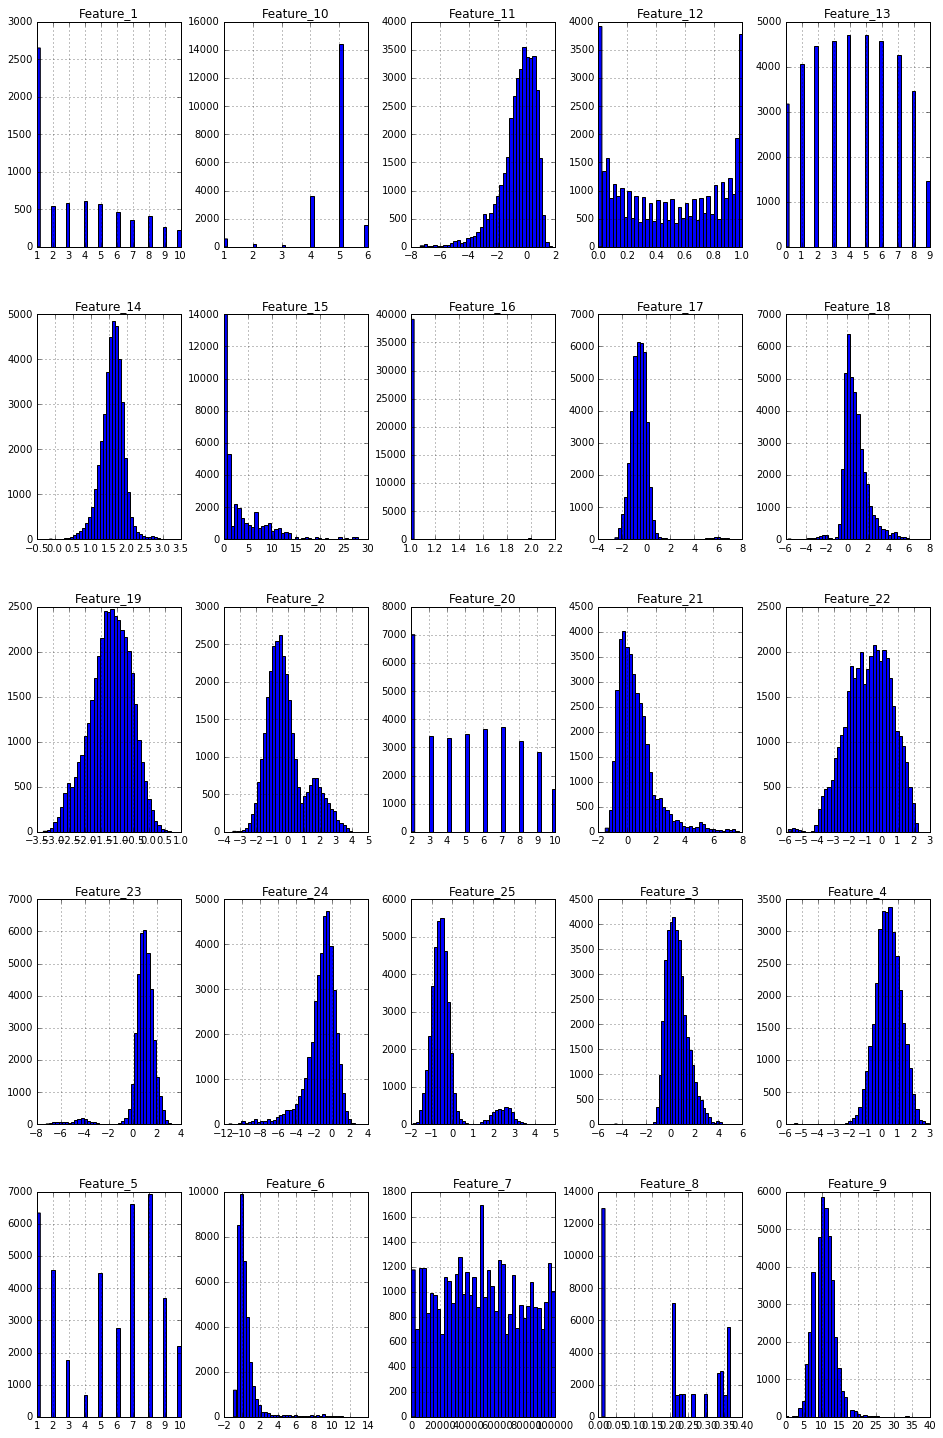

In [19]:
_data.ix[:,1:26].hist(figsize=(16,25),bins=40)
plt.show()

A few of these features look like they should be **thrown out**:
**Feature_16** is total garbage because basically every sample is 1.0

**Feature_8** appears to have a bunch of 0 values. This is probably null encoded as zero, but I don't want to replace those with the mean because the distribution is super weird.

**Feature_15** same as feature 8.

**Feature_1** similar to 8 and 15, but it does at least have a normal looking distribution. The problem is it only has 9 discrete values and they don't have very much of a signal between them. I don't like the look of this one.

**Feature_20** same as 1.

**Feature_6** doesn't have enough variance.

**Feature_10** also doesn't have enough variance.

This leaves the following features **to keep**:

2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,26

### Some interesting things to note:
**Feature_12** appears to be symmetric about 0.5. I will want to *translate 0.5-1.0 by -1.0*.
**Feature_7** looks very much like some sort of volume metric. I think this will be super important (stocks with higher volume should result in higher or lower extremes with respect to the average stock)
**Feature_2/23/25** are bimodal. Not sure what I can do with that information, but I think it's cool.


## Transforming the features:
1. Translate Feature_12 by -1.0 for all x>0.5
2. Normalize Features 2,11,12,14,17,18,19,21,22,23,24,25


In [20]:
def transform_features(_data, extra_features):
    # Transalate feature_12 by -1.0 for all x>0.5
    _data['Feature_12'].apply(lambda x: x-1.0 if x > 0.5 else x)

    # Log-transform and then normalize all of the columns we want to keep 
    to_norm = ['Feature_%s'%x for x in [2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,25]]

    # Add any additional features
    for f in extra_features:
        to_norm.append(f)
    
    # Normalize
    _data[to_norm].apply(lambda x: (x-x.mean())/(x.max()-x.min()))
    
    # Log transform
    #_data[to_norm].apply(np.log)

    # Fill the 0s that got transformed to -inf back to 0
    _data.fillna(0)




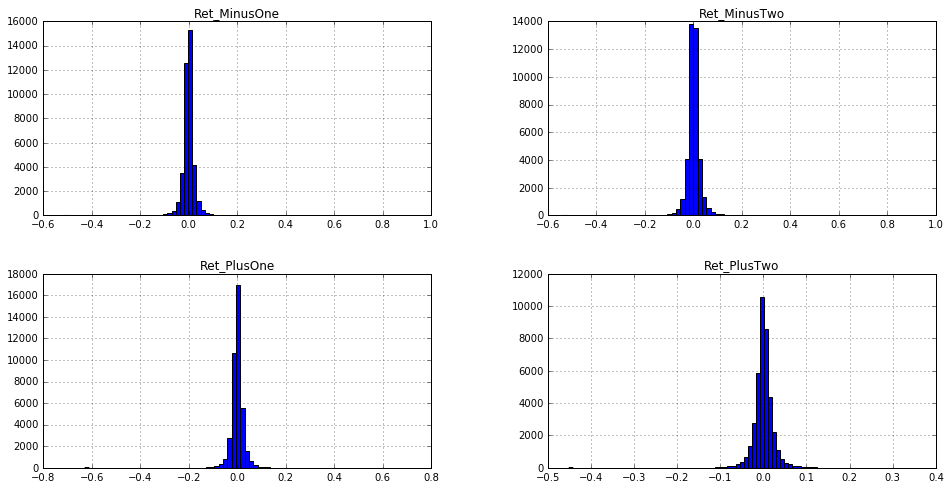

In [21]:
# Do the feature transformations
#transform_features(_data, ['Ret_MinusTwo', 'Ret_MinusOne', 'Ret_PlusOne', 'Ret_PlusTwo'])
transform_features(_data, [])

# Real quick, let's look at the D-1, D-2, D+1, and D+2 returns
_data[['Ret_MinusOne', 'Ret_MinusTwo', 'Ret_PlusOne', 'Ret_PlusTwo']].hist(figsize=(16,8),bins=80)
plt.show()

## Cross validation
Now I want to write some functions to assess how well my model is performing. I'll try to optimize the number of k-folds for an off-the-shelf SVM regressor.

In [22]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn import svm

# Take in a pandas dataframe and split it iteratively into N-folds for cross validation
# df -> pandas dataframe
# x_labels -> array of strings containing features and X values to be evaluated
# y_label -> string indicating the column we want to predict (e.g. Ret_PlusOne for D+1)
# model -> instance of scikit-learn regressor
def cross_validate(df, x_labels, y_label, model):
    
    # Arrays of mean squared error values and number of K-folds
    mse_array = []
    k_array = []
    
    for i in xrange(4, 12):
        if i%2 != 0:
            pass
        else:
            # Separate the data into X and y
            X = np.nan_to_num( np.array(df[x_labels]) )
            y = np.nan_to_num( np.array(df[y_label]) )
    
            # We want to fold based on the number of rows in df
            kf = KFold(df.shape[0], n_folds=i, shuffle=True)
    
            # Iterate through the split indices. Train and test success of model
            for train_index, test_index in kf:
                x_train, x_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
        
                # Fit the input model to the training data
                clf = model
                clf.fit(x_train, y_train)
        
                # Test predictions against actual values for test data
                mse = mean_squared_error(y_test, clf.predict(x_test))
                mse_array.append(mse)
                k_array.append(i)
    
    return mse_array, k_array



## Ret_PlusOne
I'm going to optimize the number of KFolds for Ret_PlusOne first.

In [23]:
### COMPUTE BLOCK
####################################################

#x_labels = ['Feature_%s'%x for x in [2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,25]]
#for x in ['Ret_MinusTwo', 'Ret_MinusOne']: x_labels.append(x)

#mse, k = cross_validate(_data, x_labels, 'Ret_PlusOne', svm.SVR())

#plt.plot(k, mse)
#plt.ylabel('MSE')
#plt.xlabel('Folds')
#plt.show()

The MSE is very **noisy**. This could be because many of these features are shit, but it is probably because the data itself is noisy (like most stock market data).

No reason to waste time on a higher number of folds.

### I'll stick with a low number of folds (6 looks good).

In [24]:
def train_regressors(df, folds, x_labels, y_label, model):
    
    # An array of regressors
    regressor_array = []

    kf = KFold(df.shape[0], n_folds = folds, shuffle=True)
    
    for train_index, test_index in kf:
        # Separate the data into X and y
        X = np.nan_to_num( np.array(df[x_labels]) )
        y = np.nan_to_num( np.array(df[y_label]) )
            
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model
        clf.fit(x_train, y_train)
        
        # Apend the ypred array with the latest prediction
        regressor_array.append(clf)
    
    # Return a numpy average of the ypred cols
    return regressor_array


In [25]:
### COMPUTE BLOCK
####################################################

# Train the D_1 regressors
#D_1_regressors = train_regressors(_data, 6, x_labels, 'Ret_PlusOne', svm.SVR() )

## Ret_PlusTwo
I'm going to optimize the KFolds on the other y variable **NOT** using Ret_PlusOne in the X array

In [26]:
# Labels from which to form the feature matrix (X)
x_labels = ['Feature_%s'%x for x in [2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,25]]
for x in ['Ret_MinusTwo', 'Ret_MinusOne']: x_labels.append(x)

In [27]:
### COMPUTE BLOCK
####################################################
#mse, k = cross_validate(_data, x_labels, 'Ret_PlusTwo', svm.SVR())

#plt.plot(k, mse)
#plt.ylabel('MSE')
#plt.xlabel('Folds')
#plt.show()

**6 looks good for Ret_PlusTwo as well.**

In [28]:
### COMPUTE BLOCK
####################################################

# Train the D_2 regressors
#D_2_regressors = train_regressors(_data, 6, x_labels, 'Ret_PlusTwo', svm.SVR() )

# Regression on test data
Now I need to load the test data and run the array of regressors on it. I'll average the results.

In [29]:
def test_data_regression(regressors, X):
    y_pred = []
    for r in regressors:
        y_pred.append( r.predict( np.nan_to_num(np.array(X)) ) )
    return np.mean(np.array(y_pred), axis=0)


In [30]:
### FILE I/O BLOCK
####################################################

# Load the test data into a df
test_data = pd.read_csv("%s/test_2.csv"%DATAPATH, na_values="NaN")

In [31]:
### COMPUTE BLOCK
####################################################

# Load the test data into an appropriate X matrix
#D_1_test = test_data[x_labels]

# Calculate the test predictions
#D_1 = test_data_regression(D_1_regressors, D_1_test)

In [32]:
### COMPUTE BLOCK
####################################################

# Load the test data into an appropriate X matrix
#D_2_test = test_data[x_labels]

# Calculate the test predictions
#D_2 = test_data_regression(D_2_regressors, D_2_test)

# Write to submission file

In [33]:
# This submission file will put 0s for all of the minute data (since I think predicting those is hopeless)
# and will predict only {id}_{61} and {id_62}, i.e. D+1 and D+2 returns
def write_submission_file(name, D_1, D_2):
    # I need to write a VERY simple csv file, so I'll just do it by hand and with a stupid double for loop
    with open("%s/%s"%(DATAPATH, name), "w") as f:
        # Number of rows
        n_rows = D_1.shape[0]
    
        # Headers
        f.write("Id,Predicted\n")
        count = 0
        # For each row (120,000)
        for i in xrange(n_rows):
            # For each of 60 minutes
            for j in xrange(60):
                f.write("%s_%s,%s\n"%((i+1), (j+1), 0))
                count +=1
            # D+1
            f.write("%s_%s,%s\n"%( (i+1),61, D_1[i] ) )
            # D+2
            f.write("%s_%s,%s\n"%( (i+1),62, D_2[i] ) )
            count +=2

    print "file written with %s lines"%count

In [34]:
### FILE I/O BLOCK
####################################################

# Write the file
#write_submission_file("submission_2.csv", D_1, D_2)

In [35]:
# Sanity check that the file I'm submitting has the same number of lines as the sample submission file
def submission_line_count(filepath):
    with open(filepath, "r") as f:
        for i, l in enumerate(f): pass
        print "%s lines in %s"%( (i+1), filepath)


In [36]:
#file_line_count("%s/submission_2.csv"%DATAPATH)
#file_line_count("%s/sample_submission_2.csv"%DATAPATH)

# Result 1: Lower than 0 prediction
So this didn't work at all. My first submission (I literally just submitted all zeros) was higher than this one, which is pretty terrible.

**I'm going to switch to an ensemble method because I have no idea what the features are and the data seems basically random.**

In [37]:
# Convert the dataframe into an X-matrix
def df_to_X(df):
    x_labels = ['Feature_%s'%x for x in [2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,25]]
    for x in ['Ret_MinusTwo', 'Ret_MinusOne']: x_labels.append(x)
    return df[x_labels]

In [38]:
from sklearn.ensemble import RandomForestRegressor

"""train_X = df_to_X(_data)
train_y = _data['Ret_PlusOne']

mse, k = cross_validate(_data, x_labels, 'Ret_PlusTwo', RandomForestRegressor(n_jobs=-1))

plt.plot(k, mse)
plt.ylabel('MSE')
plt.xlabel('Folds')
plt.show()"""


"train_X = df_to_X(_data)\ntrain_y = _data['Ret_PlusOne']\n\nmse, k = cross_validate(_data, x_labels, 'Ret_PlusTwo', RandomForestRegressor(n_jobs=-1))\n\nplt.plot(k, mse)\nplt.ylabel('MSE')\nplt.xlabel('Folds')\nplt.show()"

In [39]:
# Now I want to optimize the Random Forest's parameter
def regressor_mse(df, x_labels, y_label, kfolds, model):
    
    mse_array = []
    
    # Separate the data into X and y
    X = np.nan_to_num( np.array(df[x_labels]) )
    y = np.nan_to_num( np.array(df[y_label]) )
    
    # We want to fold based on the number of rows in df
    kf = KFold(df.shape[0], n_folds=kfolds, shuffle=True)
    
    # Iterate through the split indices. Train and test success of model
    for train_index, test_index in kf:
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the input model to the training data
        clf = model
        clf.fit(x_train, y_train)
        
        # Test predictions against actual values for test data
        mse_array.append( mean_squared_error(y_test, clf.predict(x_test)) )
    
    return np.mean(mse_array)

In [40]:

# Max_features: the maximum features to take into account when considering the best split.
#   By default, this is n_features, but I want to test some others
"""indices = []
mses = []

for i in xrange(1,20):
    r = RandomForestRegressor(n_estimators=i, n_jobs=-1)
    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 8, r) )
    indices.append(i)

plt.plot(indices, mses)
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()"""

"indices = []\nmses = []\n\nfor i in xrange(1,20):\n    r = RandomForestRegressor(n_estimators=i, n_jobs=-1)\n    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 8, r) )\n    indices.append(i)\n\nplt.plot(indices, mses)\nplt.ylabel('MSE')\nplt.xlabel('n_estimators')\nplt.show()"

In [41]:
# Min_samples_split: min number of samples required to split a leaf
"""indices = []
mses = []

for i in xrange(2,10):
    r = RandomForestRegressor(min_samples_split=i, n_estimators=16, n_jobs=-1)
    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 8, r) )
    indices.append(i)
    
plt.plot(indices, mses)
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()"""

"indices = []\nmses = []\n\nfor i in xrange(2,10):\n    r = RandomForestRegressor(min_samples_split=i, n_estimators=16, n_jobs=-1)\n    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 8, r) )\n    indices.append(i)\n    \nplt.plot(indices, mses)\nplt.ylabel('MSE')\nplt.xlabel('n_estimators')\nplt.show()"

In [42]:
#min_weight_fraction_leaf : float, optional (default=0.)
#The minimum weighted fraction of the input samples required to be at a leaf node. Note: this parameter is tree-specific.

"""indices = []
mses = []

for i in xrange(0,6):
    r = RandomForestRegressor(min_samples_split=8, min_weight_fraction_leaf=float(i/10), n_estimators=16, n_jobs=-1)
    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 6, r) )
    indices.append(i)
    
plt.plot(indices, mses)
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()"""

"indices = []\nmses = []\n\nfor i in xrange(0,6):\n    r = RandomForestRegressor(min_samples_split=8, min_weight_fraction_leaf=float(i/10), n_estimators=16, n_jobs=-1)\n    mses.append(regressor_mse(_data, x_labels, 'Ret_PlusOne', 6, r) )\n    indices.append(i)\n    \nplt.plot(indices, mses)\nplt.ylabel('MSE')\nplt.xlabel('n_estimators')\nplt.show()"

In [43]:
# Reverse the transformation a 1D numpy array
def reverse_transform_array(A, feature, f_mean, f_range):
    np.apply_along_axis(lambda x: x*(f_range) + f_mean, 0, A)
    np.apply_along_axis(lambda x: np.exp(x), 0, A)
    np.nan_to_num(A)
    return A
    
# Streamline this testing process
def test_regressor(regressor, train_df, test_df, f_mean, f_range):
   
    # Generate a new copy of the x_labels
    test_x_labels = ['Feature_%s'%x for x in [2,3,4,5,7,9,11,12,13,14,16,17,18,19,21,22,23,24,25]]
    test_x_labels.append('Ret_MinusTwo')
    test_x_labels.append('Ret_MinusOne')

        
    # Train the D_1 regressors
    D_1_regressors = train_regressors(train_df, 8, test_x_labels, 'Ret_PlusOne', regressor )
    D_1_test = test_df[test_x_labels]
    D_1 = test_data_regression(D_1_regressors, D_1_test)
    
    # Add Ret_PlusOne to the X matrix (this will exacerbate bias if there is any but I'm doing it anyway)
    test_x_labels.append('Ret_PlusOne')
    test_df['Ret_PlusOne'] = pd.Series(D_1)
    
    # Reverse the log-norm transformation on D_1
    #D_1 = reverse_transform_array(D_1, 'Ret_PlusOne', f_mean, f_range)
    
    # Train the D_2 regressors and de-transform D_2
    D_2_regressors = train_regressors(train_df, 8, test_x_labels, 'Ret_PlusTwo', regressor )
    D_2_test = test_df[test_x_labels]
    D_2 = test_data_regression(D_2_regressors, D_2_test)
    #D_2 = reverse_transform_array(D_2, 'Ret_PlusTwo', f_mean, f_range)
    
    return D_1, D_2

def submit(D_1, D_2, name):
    # Write the file
    write_submission_file(name, D_1, D_2)
    
    # Sanity check
    submission_line_count(name)
    submission_line_count("%s/sample_submission_2.csv"%DATAPATH)


### Note: About normalization
Since I have run these regressors on Return data that was first log_transformed and then normalized, I need to reverse this process on the predicted variables before submitting. The **problem** is that I don't know the true range of my predicted values so I can't properly de-normalize them. Thus, I will have to **estimate the mean and the range** based on the average range of both Ret_MinusOne and Ret_MinusTwo and expand the space based on that. Remember, this will be the expected mean and range in **log space**.

Since this data is so random, I don't think it will end up mattering very much, but I just want to note the additional approximation.

In [44]:
# Get the average range for both Ret_PlusOne and Ret_PlusTwo
# I need to reload the data because _data has already been transformed
re_data = pd.read_csv("%s/train.csv"%DATAPATH, na_values="NaN")

avg_mean = (re_data['Ret_PlusOne'].mean() + re_data['Ret_PlusTwo'].mean() )/2.0
avg_range = ( (re_data['Ret_PlusOne'].max()-re_data['Ret_PlusOne'].min()) - (re_data['Ret_PlusTwo'].max()-re_data['Ret_PlusTwo'].min()) )/2.0 

print "Expected mean: %s\nExpected range: %s"%(avg_mean, avg_range)

Expected mean: -9.89287708924e-05
Expected range: 0.334737368053


In [45]:
# Run the regression and write the file
r = RandomForestRegressor(min_samples_split=8, min_weight_fraction_leaf=0.3, n_estimators=17, n_jobs=-1)


D_1, D_2 = test_regressor(r, _data, test_data, avg_mean, avg_range)
#submit(D_1, D_2, "%s/submission_4.csv"%DATAPATH)

## Submission 2: Improvement on the previous submission, but still below 0 prediction benchmark

## Submission 3: Even lower

#### Transforming the features actually LOWERED my score, so for future submissions I'm not even going to bother.

#### Amazingly, NONE of my efforts to predict anything have resulted in a higher score than just submitting all 0s.

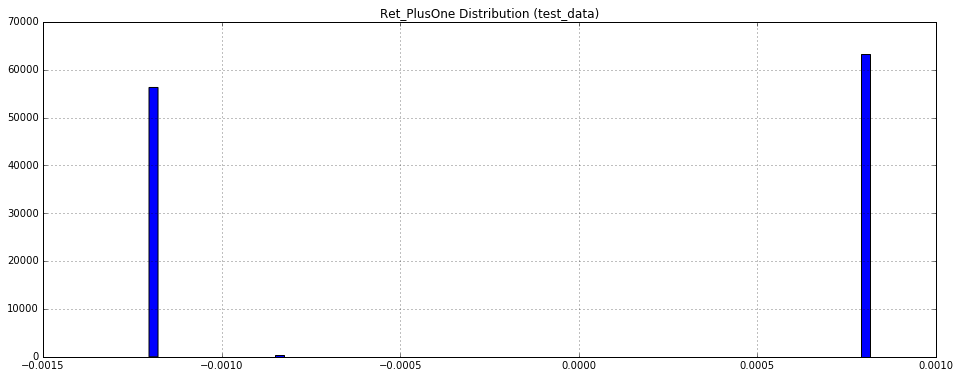

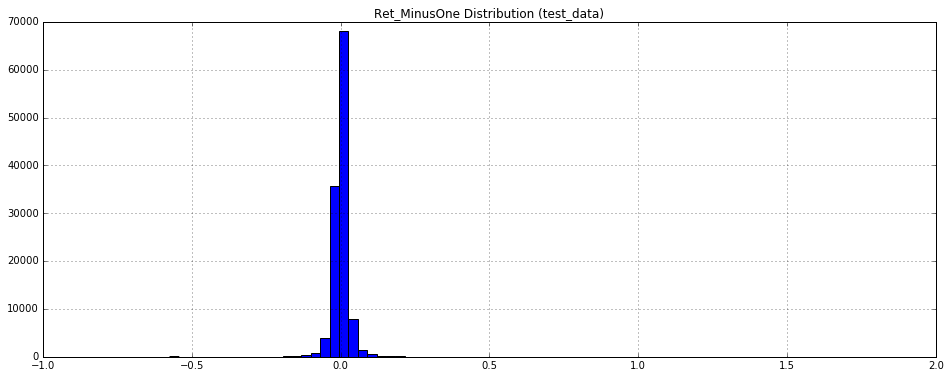

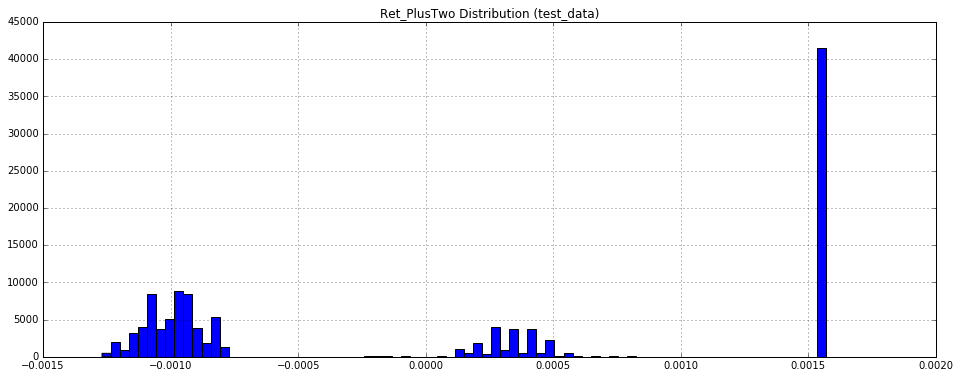

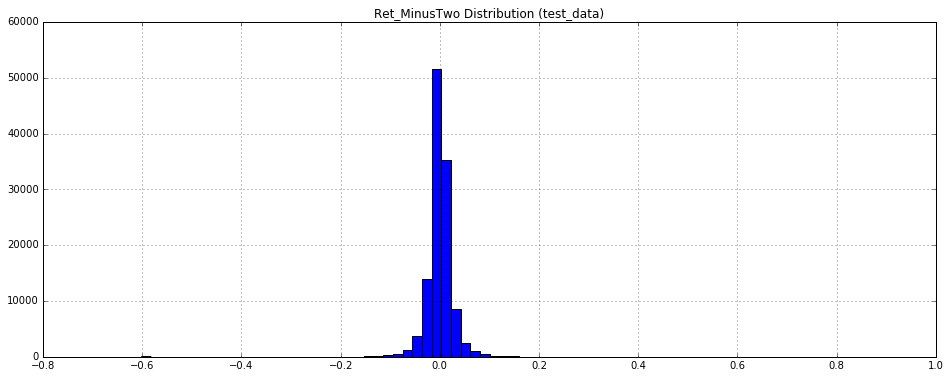

In [46]:
## Visualize the D+1 and D+2 vars
pd.Series(D_1).hist(figsize=(16,6),bins=80)
plt.title("Ret_PlusOne Distribution (test_data)")
plt.show()
test_data['Ret_MinusOne'].hist(figsize=(16,6), bins=80)
plt.title("Ret_MinusOne Distribution (test_data)")
plt.show()

pd.Series(D_2).hist(figsize=(16,6),bins=80)
plt.title("Ret_PlusTwo Distribution (test_data)")
plt.show()
test_data['Ret_MinusTwo'].hist(figsize=(16,6), bins=80)
plt.title("Ret_MinusTwo Distribution (test_data)")
plt.show()

Well, this explains why my predictions are so bad. These distributions are **way** off. The provided D-1 and D-2 distributions are **roughly Gaussian, centered around 0**. Mine are wonky pseudo-distributions that are clearly wrong.

I'm going to try approaching this **without machine learning**. I will copy the average of D-1 and D-2 to both columns and just submit that along with my zeros.

In [47]:
avg_returns = -(np.array(test_data['Ret_MinusTwo']) + np.array(test_data['Ret_MinusOne']))/2.0

submit(avg_returns, avg_returns, "%s/submission_5.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_5.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv


## Submission 5
The result was horrible (~2000 error units as opposed to the ~1770 I get with zero prediction and ~1771 I get with a random forest). Clearly the magnitudes on these are too high, so I will try the **same distribution with a much lower range**, meaning I will rewrite all outliers (>1e-05) as 0

In [48]:
# Get the distribution of average returns
avg_std = np.std(avg_returns)
avg_mean = np.mean(avg_returns)
### Restult: std=0.021, mean=6.83e-5

# I actually want a tighter distribution than this. I'll recast the mean as 0 and standard dev as 0.03
new_std = 0.001
new_mean = 0
n_samples = 120000

# Build a Gaussian distribution off of these parameters
new_dist = np.random.normal(new_mean, new_std, n_samples)


In [49]:
submit(new_dist, new_dist, "%s/submission_6.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_6.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv


## Submission 6
I'm back down to the ~1771 I had before. So basically the random forests I was running earlier were no better at predicting the outcome than a random gaussian. That's interesting...

## Next approach

So the only thing I can think of that's left to do is introduce some bias. I figure I just have to be closer to >50% of the values than the number 0 is. If we're really talking about stock data, most stocks tend to move with the market on any given day which means there are 4 combinations I can try:
1. Returns > 0 for D+1 / Returns >0 for D+2
2. Returns > 0 for D+1 / Returns <0 for D+2
3. Returns < 0 for D+1 / Returns >0 for D+2
4. Returns < 0 for D+1 / Returns >0 for D+2

I expect one of these will put me higher than the 0 prediction benchmark as long as I keep the mean close to 0 and the standard deviation ~0.001

In [54]:
# 1) D+1 mean >0; D+2 mean >0

# I'll have a tight standard deviation and two means as outlined in the combinations above
std = 0.001
mean_1 = 0.001
mean_2 = 0.001
n_samples = 120000

# Build a Gaussian distribution off of these parameters
one_dist_1 = np.random.normal(mean_1, std, n_samples)
one_dist_2 = np.random.normal(mean_2, std, n_samples)

# Generate submission
submit(one_dist_1, one_dist_2, "%s/submission_7.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_7.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv


#### --> Increased error relative to 0-prediction benchmark.

In [55]:
# 2) D+1 mean >0; D+2 mean <0

# I'll have a tight standard deviation and two means as outlined in the combinations above
std = 0.001
mean_1 = 0.001
mean_2 = -0.001
n_samples = 120000

# Build a Gaussian distribution off of these parameters
two_dist_1 = np.random.normal(mean_1, std, n_samples)
two_dist_2 = np.random.normal(mean_2, std, n_samples)

# Generate submission
submit(two_dist_1, two_dist_2, "%s/submission_8.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_8.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv


In [56]:
# 3) D+1 mean <0; D+2 mean >0

# I'll have a tight standard deviation and two means as outlined in the combinations above
std = 0.001
mean_1 = -0.001
mean_2 = 0.001
n_samples = 120000

# Build a Gaussian distribution off of these parameters
three_dist_1 = np.random.normal(mean_1, std, n_samples)
three_dist_2 = np.random.normal(mean_2, std, n_samples)

# Generate submission
submit(three_dist_1, three_dist_2, "%s/submission_9.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_9.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv


In [57]:
# 4) D+1 mean <0; D+2 mean <0

# I'll have a tight standard deviation and two means as outlined in the combinations above
std = 0.001
mean_1 = -0.001
mean_2 = -0.001
n_samples = 120000

# Build a Gaussian distribution off of these parameters
four_dist_1 = np.random.normal(mean_1, std, n_samples)
four_dist_2 = np.random.normal(mean_2, std, n_samples)

# Generate submission
submit(four_dist_1, four_dist_2, "%s/submission_10.csv"%DATAPATH)

file written with 7440000 lines
7440001 lines in ../../data/stocks_2015/submission_10.csv
7440001 lines in ../../data/stocks_2015/sample_submission_2.csv
